### Training loop stuff


In [ ]:
# | default_exp training
# | hide
import nbdev

nbdev.nbdev_export()
from nbdev.showdoc import *

In [ ]:
# | export
from tidygrad.tensor import Tensor
from tidygrad.utils import noop
import numpy as np
import fastprogress

In [ ]:
# | export
def add_callbacks(func):
    # print("Adding callbacks", func.__name__)

    def decorator(self):
        full_name = func.__name__.replace("do_", "")
        pre_name = f"pre_{full_name}"
        post_name = f"post_{full_name}"
        for callback in self.callbacks:
            getattr(callback, pre_name, noop)(self)

        func(self)
        for callback in self.callbacks:
            getattr(callback, post_name, noop)(self)

    return decorator

In [ ]:
class Metric:
    def __init__(self, train=True, valid=True):
        self.train = train
        self.valid = valid
    @staticmethod
    def calc() -> float:
        raise NotImplementedError

class MultiClassAccuracy(Metric):
    name = "accuracy"

    @staticmethod
    def calc(learner) -> float:
        _, y = learner.batch
        return float((learner.preds.data.argmax(axis=-1) == y.data).mean())

class Loss(Metric):
    name = "loss"

    @staticmethod
    def calc(learner) -> float:
        return float(learner.loss.data)

In [ ]:
# | export

class DictLoggerCallback:
    val_loss = 0
    val_error = 0

    def __init__(self, metrics=None, history=None):
        self.metrics = [MultiClassAccuracy(), Loss()] if metrics is None else metrics
        self.history = [] if history is None else history

    def log(self, learner, metric, value, accum=False, step: int = None):
        if not hasattr(learner, "metrics"): learner.metrics = self.history
        if step is None:
            step = self.history[-1]["step"] + 1 if self.history else 0

        if not self.history or step != self.history[-1]["step"]:
            self.history.append({"step": step})

        if metric in self.history[-1] and accum:
            self.history[-1][metric] += value
        else:
            self.history[-1][metric] = value

    def post_calc_loss(self, learner):
        for m in self.metrics:
            if learner.training:
                if m.train: self.log(learner, f"train_{m.name}", m.calc(learner), accum=False, step=learner.step)
            else:
                if m.valid: self.log(learner, f"val_{m.name}", m.calc(learner), accum=True, step=learner.step)

    def post_epoch(self, learner):
        for m in self.metrics:
            if f"val_{m.name}" in self.history[-1]:
                self.history[-1][f"val_{m.name}"] /= len(learner.dl)


In [ ]:
# | export

class Learner:
    # dataloaders - train, test
    # model - function that outputs a tensor that can be fed into a loss function
    # loss_func - function that takes in a tensor and outputs a scalar
    # optimizer - Optimizer object
    def __init__(self, dataloaders, model, loss_func, optimizer, callbacks=[]):
        self.dataloaders = dataloaders
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.callbacks = callbacks if callbacks else []

        # The state of the learner. These are updated during training by various do_ functions
        self.training = False  # True if training, False if val/test.
        self.epoch = 0  # current epoch, starts with 1 when you start trainig.
        self.step = 0  # current step, increases by 1 every (training) batch
        self.dl = None  # current dataloader, could be train or test or val
        self.batch = None  # The current batch as a tuple of (x, y)
        self.preds: Tensor = None  # Output of the model

    def fit(self, epochs, start_epoch=0, start_step=None):
        self.start_epoch = start_epoch
        self.n_epochs = epochs
        self.step = self.step if start_step is None else start_step
        self.do_fit()

    @add_callbacks
    def do_fit(self):
        for e in range(self.start_epoch + 1, self.start_epoch + 1 + self.n_epochs):
            self.epoch = e
            self.do_epoch()

    @add_callbacks
    def do_epoch(self):
        self.training = True
        self.dl = self.dataloaders.train
        self.do_all_batches()
        self.dl = self.dataloaders.test
        self.training = False
        self.do_all_batches()

    @add_callbacks
    def do_all_batches(self):
        for batch in self.dl:
            if self.training: self.step += 1
            self.batch = batch
            self.do_batch_forward()
            self.do_calc_loss()
            if self.training: self.do_batch_backward()

    @add_callbacks
    def do_calc_loss(self):
        _, y = self.batch
        self.loss = self.loss_func(self.preds, y)

    @add_callbacks
    def do_batch_forward(self):
        x, _ = self.batch
        self.preds = self.model(x)

    @add_callbacks
    def do_batch_backward(self):
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [ ]:
#| export
from tqdm.auto import tqdm

In [ ]:
#| export
class ProgressBarCallback:
    def __init__(self):
        pass

    def pre_all_batches(self, learner):
        if learner.training:
            self.pbar = tqdm(total=len(learner.dl), desc=f"Epoch {learner.epoch}")

    def post_calc_loss(self, learner):
        if learner.training:
            # print(learner.metrics[-1]["loss"])
            self.pbar.update(1)
            self.pbar.set_postfix_str(f"loss={learner.metrics[-1]['loss']:.4f}, error={learner.metrics[-1]['error']:.4f}")

In [ ]:
#| export
def one_hot_encode_batch(y, n_classes):
    batch_size = len(y)
    assert batch_size > 0
    assert n_classes > 0
    assert y.shape == (batch_size, )
    assert np.min(y) >= 0

    # Initialize a zero matrix of shape (batch_size, num_classes)
    one_hot_matrix = np.zeros((batch_size, n_classes))

    # Fill in the appropriate elements
    one_hot_matrix[np.arange(batch_size), y] = 1

    return Tensor(one_hot_matrix)

In [ ]:
from tidygrad.utils.data import DataLoader, DataLoaders
from tidygrad.utils.datasets import MNIST, mnist_batch_tfm
from tidygrad.functional import sigmoid, BCE_loss, CrossEntropy_loss
from tidygrad.optim import Adam
from functools import partial
from matplotlib import pyplot as plt

In [ ]:
BS = 1024

mnist_train = DataLoader(MNIST(fashion=True), batch_size=BS, shuffle=False, batch_tfms=[mnist_batch_tfm])
mnist_test = DataLoader(MNIST(train=False, fashion=True), batch_size=BS, shuffle=False, batch_tfms=[mnist_batch_tfm])

INT_DIM = 128

w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")
w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")

def linear_model(inputs, params, debug=list()):
    inputs.data = inputs.data.reshape(inputs.data.shape[0], -1)
    x = inputs
    w1, b1, w2 = params
    z1 = sigmoid(x.mmul(w1, "z1") + b1)
    z2 = z1.mmul(w2, "z2")

    return z2

MM_func = partial(linear_model, params=[w1, b1, w2])
optimizer = Adam([w1, b1, w2], lr=0.005)

loss_f = lambda preds, targets: CrossEntropy_loss(preds, one_hot_encode_batch(targets.data, n_classes=10))
# loss_f = lambda preds, targets: CrossEntropy_loss(preds, one_hot_encode_batch(targets.data, 10))

student = Learner(
    dataloaders=DataLoaders(mnist_train, mnist_test),
    model=MM_func,
    loss_func=loss_f,
    optimizer=optimizer,
    callbacks=[DictLoggerCallback()],
)

File datasets/train-images-idx3-ubyte.gz already exists
File datasets/train-labels-idx1-ubyte.gz already exists
File datasets/t10k-images-idx3-ubyte.gz already exists
File datasets/t10k-labels-idx1-ubyte.gz already exists


In [ ]:
#| eval: false
student.fit(epochs=5)
student.metrics[-3:]

[{'step': 288,
  'train_accuracy': 0.81640625,
  'train_loss': 0.05720346066139017},
 {'step': 289,
  'train_accuracy': 0.8232421875,
  'train_loss': 0.05059806939207382},
 {'step': 290,
  'train_accuracy': 0.828125,
  'train_loss': 0.0510430000767627,
  'val_accuracy': 0.7995876736111112,
  'val_loss': 0.061950079509605044}]

In [ ]:
# BCE loss:

# {'step': 4685,
#  'loss': 0.07427763076147674,
#  'error': 0.09375,
#  'val_loss': 0.05190171994043634,
#  'val_error': 0.07572115384615384}

# Cross entropy loss
# {'step': 4685,
#  'loss': 0.04031534545340052,
#  'error': 0.078125,
#  'val_loss': 0.026959319073845904,
#  'val_error': 0.07872596153846154}

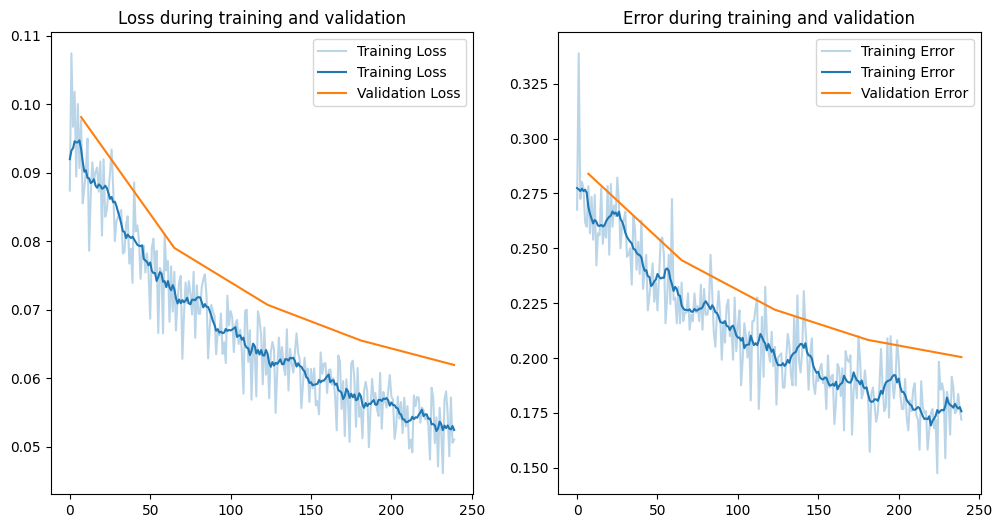

In [ ]:
#| eval: false

losses = []
errors = []
val_losses = []
val_errors = []

for idx, data in enumerate(student.metrics[50:]):
    if 'train_loss' in data: losses.append((idx, data['train_loss']))
    if 'train_accuracy' in data: errors.append((idx, 1-data['train_accuracy']))
    if 'val_loss' in data: val_losses.append((idx, data['val_loss']))
    if 'val_accuracy' in data: val_errors.append((idx, 1-data['val_accuracy']))

def denoise(L):
    i = [i for i, _ in L]
    x = np.array([x for _, x in L])
    
    window_size = 10
    pad_size = window_size // 2
    
    # Pad the array with constant values at both ends
    x_padded = np.pad(x, (pad_size, pad_size), 'edge')
    
    # Create a window for moving average
    window = np.ones(window_size) / window_size
    
    # Apply convolution on the padded array
    xx = np.convolve(x_padded, window, mode='valid')
    
    return [(p, q) for p, q in zip(i, xx)]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
line1, = plt.plot(*zip(*losses), alpha=.3, label='Training Loss')
plt.plot(*zip(*denoise(losses)), color=line1.get_color(), label='Training Loss')
plt.plot(*zip(*val_losses), label='Validation Loss')
plt.title('Loss during training and validation')
plt.legend()

plt.subplot(1, 2, 2)
line1, = plt.plot(*zip(*errors), alpha=.3, label='Training Error')
plt.plot(*zip(*denoise(errors)), color=line1.get_color(), label='Training Error')
plt.plot(*zip(*val_errors), label='Validation Error')
plt.title('Error during training and validation')
plt.legend()

plt.show()